In [1]:
import pandas as pd
import json
import numpy as np

import matplotlib.pyplot as plt
from ast import literal_eval
from dotenv import load_dotenv 
import os
from PIL import Image
from wordcloud import WordCloud

In [2]:
# loading variables from .env file
load_dotenv("../../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")

RECORD_IDS_TESTING_SET = PARENT + os.getenv("RECORD_IDS_TESTING_SET")
RECORD_IDS_VALIDATION_SET = PARENT + os.getenv("RECORD_IDS_VALIDATION_SET")
RECORD_IDS_TRAINING_SET = PARENT + os.getenv("RECORD_IDS_TRAINING_SET")

WRITTEN_CAPTIONS_TESTING_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_TESTING_SET")
WRITTEN_CAPTIONS_VALIDATION_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_VALIDATION_SET")
WRITTEN_CAPTIONS_TRAINING_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_TRAINING_SET")

DB_INPUT_ARTPIECES = PARENT + os.getenv("DB_INPUT_ARTPIECES")
DB_INPUT_ARTISTS = PARENT + os.getenv("DB_INPUT_ARTISTS")

BENCHMARK_2_ATTACHED = PARENT + os.getenv("BENCHMARK_2_ATTACHED")
BENCHMARK_2_EXPLODED = PARENT + os.getenv("BENCHMARK_2_EXPLODED")

In [3]:
# Get the artworks data
ARTWORKS = pd.read_csv(DB_INPUT_ARTPIECES)
ARTWORKS.head(1)

,recordID,workID,creatorID,language,title,objectWorkType,termClassification,materials,signatureFullDescription,creationFullDescription,...,physicalAppearanceDescription,imageType,imageColor,imageLowResFilename,imageHighResFilename,imageCopyright,formalDescriptionTermStylesPeriods,height,width,ratio
0,64,8181,Auth:509:309,fre,La Crucifixion,détrempe,peinture (Dept. Art Ancien),toile|tempera,NaN,1460.0,...,Tempera sur toile,digitale JPG,photo couleurs,/art-foto/old/internet/Bouts-8181dig-L.jpg,/art-foto/old/intranet/Bouts-8181dig-H.jpg,NaN,Primitifs flamands,181.5,153.5,0.84573


In [4]:
def fixPath(path):
    return path.replace(".././", "../")

def get_image_path_from_recordID(recordID):
    """
    Given a recordID, return the local path for its image.
    """
    # Locate row in the downloaded DataFrame
    paths = ARTWORKS[
        ARTWORKS["recordID"] == recordID
    ]["imageLowResFilename"].values
    
    if len(paths) == 0:
        return None
    
    path = paths[0]
    # Merge: IMAGES_FOLDER + path[1:]
    merged_path = fixPath(os.path.join(IMAGES_FOLDER, path[1:]))
    return merged_path

In [5]:
# Get the artworks data
ARTISTS = pd.read_csv(DB_INPUT_ARTISTS)
ARTISTS.head(1)

,creatorID,creatorLastName,creatorFirstName,creatorBirthAndDeathDescription,creatorNationality,creatorDeathDate,creatorBirthDate
0,Auth:509:309,Bouts,Dirk,Haarlem (Pays-Bas) vers 1410 ? - Louvain 1475,NaN,1475.0,1410.0


In [6]:
def v_literal_eval(val):
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError):
        return np.nan

In [7]:
DATA_EXPLODED = pd.read_csv(BENCHMARK_2_EXPLODED, converters={'recordID': v_literal_eval})

In [8]:
DATA_ATTACHED = pd.read_csv(BENCHMARK_2_ATTACHED)
DATA_ATTACHED

,recordID,proper_nouns,tokenized_length
0,64,"Jésus, Nouveau Testament, Passion, Evangiles, ...",31
1,78,Louise van der Hecht,7
2,79,Robert Schumann,5
3,81,Marguerite Khnopff,8
4,105,"Cupidon, Ariane, Bacchus",11
...,...,...,...
1896,11252,Namur,4
1897,11521,"Andromède, Persée, Céto",12
1898,11525,"Nicolas-Henri Tardieu, Marie-Anne Hortemels",15
1899,11533,"Rik Wouters, Nel Wouters, Amsterdam",13


In [9]:
DATA_EXPLODED = pd.read_csv(BENCHMARK_2_EXPLODED, converters={'recordID': v_literal_eval})
print(DATA_EXPLODED["recordID"].sample(1).dtype)
DATA_EXPLODED

object


,proper_nouns,recordID
0,Aar,[8437]
1,Ab Urbe Condita,[1369]
2,Abigaïl,[5299]
3,Abraham,"[6622, 7295]"
4,Abraham Bloemaert,[5354]
...,...,...
1660,Zélande,"[625, 1598, 7587, 8256]"
1661,Égypte,[1062]
1662,Élysée Reclus,[10189]
1663,Énée,[10241]


In [10]:
import pickle
models_name = [
    "basic-mini",
    "basic-base",
    "basic-large",
    "march_finetuned",
    "february_finetuned",
    "art-mini",
    "art-base",
    "art-large",
]
data = {}
for model_name in models_name:
    data[model_name] = {}
    data[model_name]["attached"] = {}
    data[model_name]["attached"]["metrics"] = pd.read_csv(f"../../benchmarks/benchmark_2/{model_name}_attached.csv")
    data[model_name]["attached"]["positions"] = pickle.load(open(f"../../benchmarks/benchmark_2/{model_name}_positions_attached.pkl", "rb"))
    data[model_name]["exploded"] = pd.read_csv(f"../../benchmarks/benchmark_2/{model_name}_exploded.csv")

data["art-base"]["attached"]["metrics"]

,average_position,mrr,recall@1,recall@3,recall@5,recall@10,nDCG@1,nDCG@3,nDCG@5,nDCG@10
0,68.956339,0.243487,0.13151,0.271962,0.35192,0.472383,0.13151,0.212962,0.245923,0.284895


In [11]:
# Merge all the dataframes
df_attached = pd.DataFrame()
for model_name in models_name:
    df = data[model_name]["attached"]["metrics"]
    df["model_name"] = model_name
    df_attached = pd.concat([df_attached, df], ignore_index=True)

# Put model_name in the first column
cols = df_attached.columns.tolist()
cols.insert(0, cols.pop(cols.index("model_name")))
df_attached = df_attached[cols]

colsToRound = df_attached.columns[1:]
for col in colsToRound:
    df_attached[col] = df_attached[col].round(4)

df_attached.to_csv("../../CSV/benchmark_2_attached__.csv", index=False)
df_attached

,model_name,average_position,mrr,recall@1,recall@3,recall@5,recall@10,nDCG@1,nDCG@3,nDCG@5,nDCG@10
0,basic-mini,409.7033,0.0467,0.0205,0.0426,0.0584,0.0821,0.0205,0.0333,0.0398,0.0474
1,basic-base,333.1152,0.0748,0.0347,0.0773,0.1005,0.1394,0.0347,0.0593,0.0688,0.0813
2,basic-large,312.4955,0.0774,0.0363,0.0773,0.1026,0.1499,0.0363,0.0596,0.0701,0.0853
3,march_finetuned,126.1799,0.1474,0.0710,0.1478,0.2004,0.3135,0.0710,0.1146,0.1363,0.1728
4,february_finetuned,314.8459,0.0788,0.0379,0.0752,0.1026,0.1547,0.0379,0.0594,0.0706,0.0873
5,art-mini,179.4371,0.1301,0.0673,0.1341,0.1767,0.2504,0.0673,0.1058,0.1234,0.1472
6,art-base,68.9563,0.2435,0.1315,0.2720,0.3519,0.4724,0.1315,0.2130,0.2459,0.2849
7,art-large,75.4093,0.2136,0.1142,0.2283,0.3083,0.4156,0.1142,0.1800,0.2129,0.2474


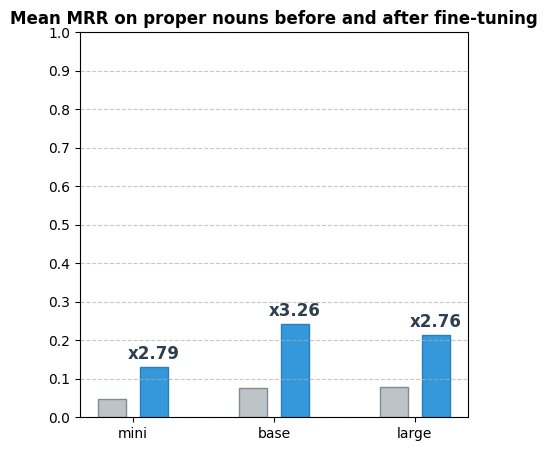

In [12]:
# Reorder the columns model_name such that it follows the order in models_name
plt.figure(figsize=(5, 5))

plt.grid(axis='y', linestyle='--', alpha=0.7)

for model_size_x, model_size in enumerate(["mini", "base", "large"]):
    base_result = df_attached[df_attached["model_name"] == f"basic-{model_size}"]["mrr"].values[0]
    art_result = df_attached[df_attached["model_name"] == f"art-{model_size}"]["mrr"].values[0]
    plt.bar(
        model_size_x - 0.15,
        base_result,
        width=0.2,
        label=f"basic-{model_size}",
        color="#bdc3c7",
        edgecolor="#7f8c8d"
    )
    plt.bar(
        model_size_x + 0.15,
        art_result,
        width=0.2,
        label=f"art-{model_size}",
        color="#3498db",
        edgecolor="#2980b9"
    )
    # Add a text above the art_result bar
    xDifference = round(art_result/base_result, 2)
    xDifference = f"x{xDifference}"
    plt.text(
        model_size_x + 0.15,
        art_result + 0.01,
        xDifference,
        ha='center',
        va='bottom',
        fontsize=12,
        color="#2c3e50",
        fontweight='bold'
    )


plt.title("Mean MRR on proper nouns before and after fine-tuning", fontsize=12, fontweight='bold')
plt.xticks([0, 1, 2], ["mini", "base", "large"])
plt.ylim(0, 1)

y_ticks = np.arange(0, 1.1, 0.1)
plt.yticks(y_ticks)

plt.show()

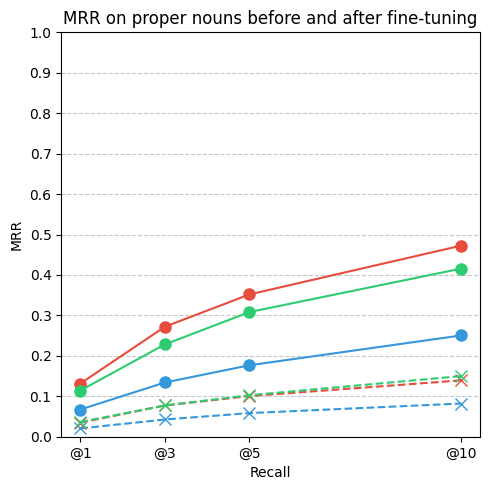

In [13]:
# Reorder the columns model_name such that it follows the order in models_name
plt.figure(figsize=(5, 5))

plt.grid(axis='y', linestyle='--', alpha=0.7)

color_per_model_size = {
    "mini": "#3498db",
    "base": "#e74c3c",
    "large": "#2ecc71",
}

linestyle_per_finetuned = {
    True: "-",
    False: "--",
}

marker_per_finetuned = {
    True: "o",
    False: "x",
}

for model_size_x, model_size in enumerate(["mini", "base", "large"]):
    recalls = [1,3,5,10]
    values = {
        False: [],
        True: []
    }
    for recall in recalls:
        columnName = f"recall@{recall}"
        base_result = df_attached[df_attached["model_name"] == f"basic-{model_size}"][columnName].values[0]
        art_result = df_attached[df_attached["model_name"] == f"art-{model_size}"][columnName].values[0]
        values[False].append(base_result)
        values[True].append(art_result)

    for finetuned in [False, True]:
        model_name = f"art-{model_size}" if finetuned else f"basic-{model_size}"
        plt.plot(
            recalls,
            values[finetuned],
            label=model_name,
            color=color_per_model_size[model_size],
            linestyle=linestyle_per_finetuned[finetuned],
            marker=marker_per_finetuned[finetuned],
            markersize=8,
        )


plt.title("MRR on proper nouns before and after fine-tuning")
plt.xticks(recalls, [f"@{recall}" for recall in recalls])
plt.ylim(0, 1)

y_ticks = np.arange(0, 1.1, 0.1)
plt.yticks(y_ticks)
plt.xlabel("Recall")
plt.ylabel("MRR")

plt.tight_layout()
plt.show()

In [14]:
def get_table():
    table = df_attached.copy()
    # Columns for training_data
    table["training_data"] = [
        "N/A",
        "N/A",
        "N/A",
        "cap-FR-1",
        "cap-FR-2 \& ico-FR",
        "cap-TRI \& ico-TRI",
        "cap-TRI \& ico-TRI",
        "cap-TRI \& ico-TRI",
    ]
    table["pretrained_model"] = [
        "B/32",
        "L/14",
        "L/14@336px",
        "L/14",
        "L/14",
        "B/32",
        "L/14",
        "L/14@336px",
    ]
    # Round specific columns
    round_factor = 3
    numeric_columns = [
        "average_position",
        "mrr",
        "recall@1",
        "recall@3",
        "recall@5",
        "recall@10",
        "recall@3",
        "nDCG@5",
        "nDCG@3",
        "nDCG@10",
    ]
    for col in numeric_columns:
        table[col] = table[col].round(round_factor)
        if col == "average_position":
            best_value = table[col].min()
        else:
            best_value = table[col].max() 
        
        # Bold the value if it is the best in the column
        table[col] = table[col].apply(lambda x: f"\\textbf{{{x}}}" if x == best_value else str(x))
    # For each numeric column, bold the value
    # Reorder columns
    table = table[["training_data", "pretrained_model", "model_name", "average_position", "mrr", "recall@1", "recall@3", "recall@5", "recall@10", "nDCG@3", "nDCG@5", "nDCG@10"]]
    # Rename columns
    table = table.rename(columns={
        "training_data": "Dataset",
        "pretrained_model": "ViT",
        "model_name": "Model",
        "average_position": "Avg. Pos.",
        "mrr": "MRR",
        "recall@1": "Recall@1",
        "recall@3": "Recall@3",
        "recall@5": "Recall@5",
        "recall@10": "Recall@10",
        "nDCG@3": "nDCG@3",
        "nDCG@5": "nDCG@5",
        "nDCG@10": "nDCG@10",
    })
    # drop index
    table = table.reset_index(drop=True)
    return table

import write_latex as WL

tab = get_table()

print(WL.get_latex_summary_table(tab))


        \begin{table}[]
        \centering
        \resizebox{\columnwidth}{!}{%
        \begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|}
        \hline
        \textbf{Dataset} & \textbf{ViT} & \textbf{Model} & \textbf{Avg. Pos.} & \textbf{MRR} & \textbf{Recall@1} & \textbf{Recall@3} & \textbf{Recall@5} & \textbf{Recall@10} & \textbf{nDCG@3} & \textbf{nDCG@5} & \textbf{nDCG@10} \\ \hline
        \multirow{3}{*}{N/A} & B/32 & basic-mini & 409.703 & 0.047 & 0.02 & 0.043 & 0.058 & 0.082 & 0.033 & 0.04 & 0.047 \\ \cline{2-12} 
        & L/14 & basic-base & 333.115 & 0.075 & 0.035 & 0.077 & 0.1 & 0.139 & 0.059 & 0.069 & 0.081 \\ \cline{2-12} 
        & L/14@336px & basic-large & 312.496 & 0.077 & 0.036 & 0.077 & 0.103 & 0.15 & 0.06 & 0.07 & 0.085 \\ \hline
        cap-FR-1 & \multirow{2}{*}{L/14} & february\_finetuned & 126.18 & 0.147 & 0.071 & 0.148 & 0.2 & 0.314 & 0.115 & 0.136 & 0.173 \\ \cline{1-1} \cline{3-12} 
        cap-FR-2 \& ico-FR &  & march\_finetuned & 314.846 & 0.079 & 0.038 & 0.

In [15]:
import ast

model_name_to_all_ranks = {}

minRank = 1
maxRank = -1

cutoff = len(data["art-base"]["exploded"])

for modelIndex, model_name in enumerate(models_name):
    df = data[model_name]["exploded"]
    # ['overall_average_rank', 'average_rank', 'ranks', 'positions']
    all_ranks = []
    for i, row in df.iterrows():
        # Get the ranks
        ranks = ast.literal_eval(row["ranks"])
        R = min(ranks)
        if R > cutoff:
            continue
        all_ranks.append(R)

    model_name_to_all_ranks[model_name] = all_ranks
    
    maxRank = max(maxRank, max(all_ranks))

res = pd.DataFrame(columns=["Model name", "1", "3", "5", "10", "20", "30"])
for model_name in models_name:
    all_ranks = model_name_to_all_ranks[model_name]

    u1 = len([x for x in all_ranks if x <= 1]) / len(all_ranks)
    u3 = len([x for x in all_ranks if x <= 3]) / len(all_ranks)
    u5 = len([x for x in all_ranks if x <= 5]) / len(all_ranks)
    u10 = len([x for x in all_ranks if x <= 10]) / len(all_ranks)
    u20 = len([x for x in all_ranks if x <= 20]) / len(all_ranks)
    u30 = len([x for x in all_ranks if x <= 30]) / len(all_ranks)

    res.loc[model_name] = [model_name, u1, u3, u5, u10, u20, u30]

res[["1", "3", "5", "10", "20", "30"]] = res[["1", "3", "5", "10", "20", "30"]].astype(float).round(4)

res.to_csv("../../CSV/benchmark_2_exploded_u.csv", index=False)
res

,Model name,1,3,5,10,20,30
basic-mini,basic-mini,0.0288,0.0539,0.0671,0.0978,0.1436,0.1737
basic-base,basic-base,0.0493,0.0813,0.1023,0.1337,0.1867,0.2323
basic-large,basic-large,0.0497,0.0851,0.1119,0.1467,0.1877,0.2356
march_finetuned,march_finetuned,0.0890,0.1568,0.1889,0.2579,0.3396,0.3929
february_finetuned,february_finetuned,0.0512,0.0882,0.1172,0.1499,0.2023,0.2320
art-mini,art-mini,0.0845,0.1296,0.1563,0.2019,0.2603,0.3054
art-base,art-base,0.1493,0.2515,0.3011,0.3845,0.4674,0.5151
art-large,art-large,0.1332,0.2203,0.2748,0.3481,0.4304,0.4806


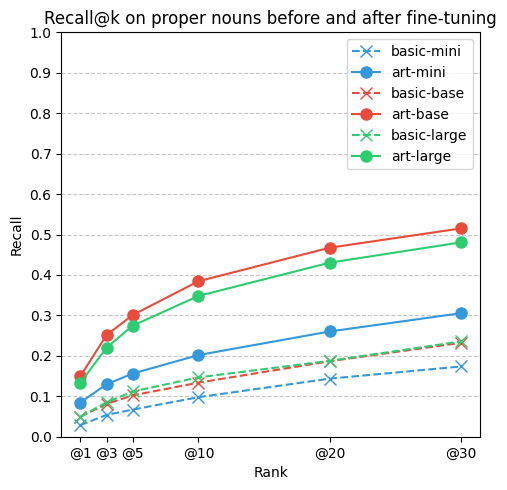

In [16]:
color_per_model_size = {
    "mini": "#3498db",
    "base": "#e74c3c",
    "large": "#2ecc71",
}

linestyle_per_finetuned = {
    True: "-",
    False: "--",
}

marker_per_finetuned = {
    True: "o",
    False: "x",
}

plt.figure(figsize=(5, 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)

for model_size_x, model_size in enumerate(["mini", "base", "large"]):
    recalls = [1,3,5,10,20,30]
    values = {
        False: [],
        True: []
    }
    for recall in recalls:
        columnName = str(recall)
        base_result = res[res["Model name"] == f"basic-{model_size}"][columnName].values[0]
        art_result = res[res["Model name"] == f"art-{model_size}"][columnName].values[0]
        values[False].append(base_result)
        values[True].append(art_result)


    for finetuned in [False, True]:
        model_name = f"art-{model_size}" if finetuned else f"basic-{model_size}"
        plt.plot(
            recalls,
            values[finetuned],
            label=model_name,
            color=color_per_model_size[model_size],
            linestyle=linestyle_per_finetuned[finetuned],
            marker=marker_per_finetuned[finetuned],
            markersize=8,
        )

plt.title("Recall@k on proper nouns before and after fine-tuning")
plt.xticks(recalls, [f"@{recall}" for recall in recalls])
plt.ylim(0, 1)
y_ticks = np.arange(0, 1.1, 0.1)
plt.yticks(y_ticks)
plt.xlabel("Rank")
plt.ylabel("Recall")
plt.legend(loc="upper right", fontsize=10)
plt.tight_layout()

In [17]:
DATA_EXPLODED

,proper_nouns,recordID
0,Aar,[8437]
1,Ab Urbe Condita,[1369]
2,Abigaïl,[5299]
3,Abraham,"[6622, 7295]"
4,Abraham Bloemaert,[5354]
...,...,...
1660,Zélande,"[625, 1598, 7587, 8256]"
1661,Égypte,[1062]
1662,Élysée Reclus,[10189]
1663,Énée,[10241]


In [18]:
DATA_EXPLODED["len"] = DATA_EXPLODED["recordID"].apply(lambda x: len(x))
mean_len = DATA_EXPLODED["len"].mean()
print(f"Mean length of recordID: {mean_len}")

Mean length of recordID: 2.854054054054054


In [19]:
DATA_ATTACHED


,recordID,proper_nouns,tokenized_length
0,64,"Jésus, Nouveau Testament, Passion, Evangiles, ...",31
1,78,Louise van der Hecht,7
2,79,Robert Schumann,5
3,81,Marguerite Khnopff,8
4,105,"Cupidon, Ariane, Bacchus",11
...,...,...,...
1896,11252,Namur,4
1897,11521,"Andromède, Persée, Céto",12
1898,11525,"Nicolas-Henri Tardieu, Marie-Anne Hortemels",15
1899,11533,"Rik Wouters, Nel Wouters, Amsterdam",13


Mean Rank Regression:
  Slope: 0.5862, R²: 0.0184, p-value: 0.3920
STD Regression:
  Slope: -0.5564, R²: 0.0352, p-value: 0.2342


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1000x500 with 0 Axes>

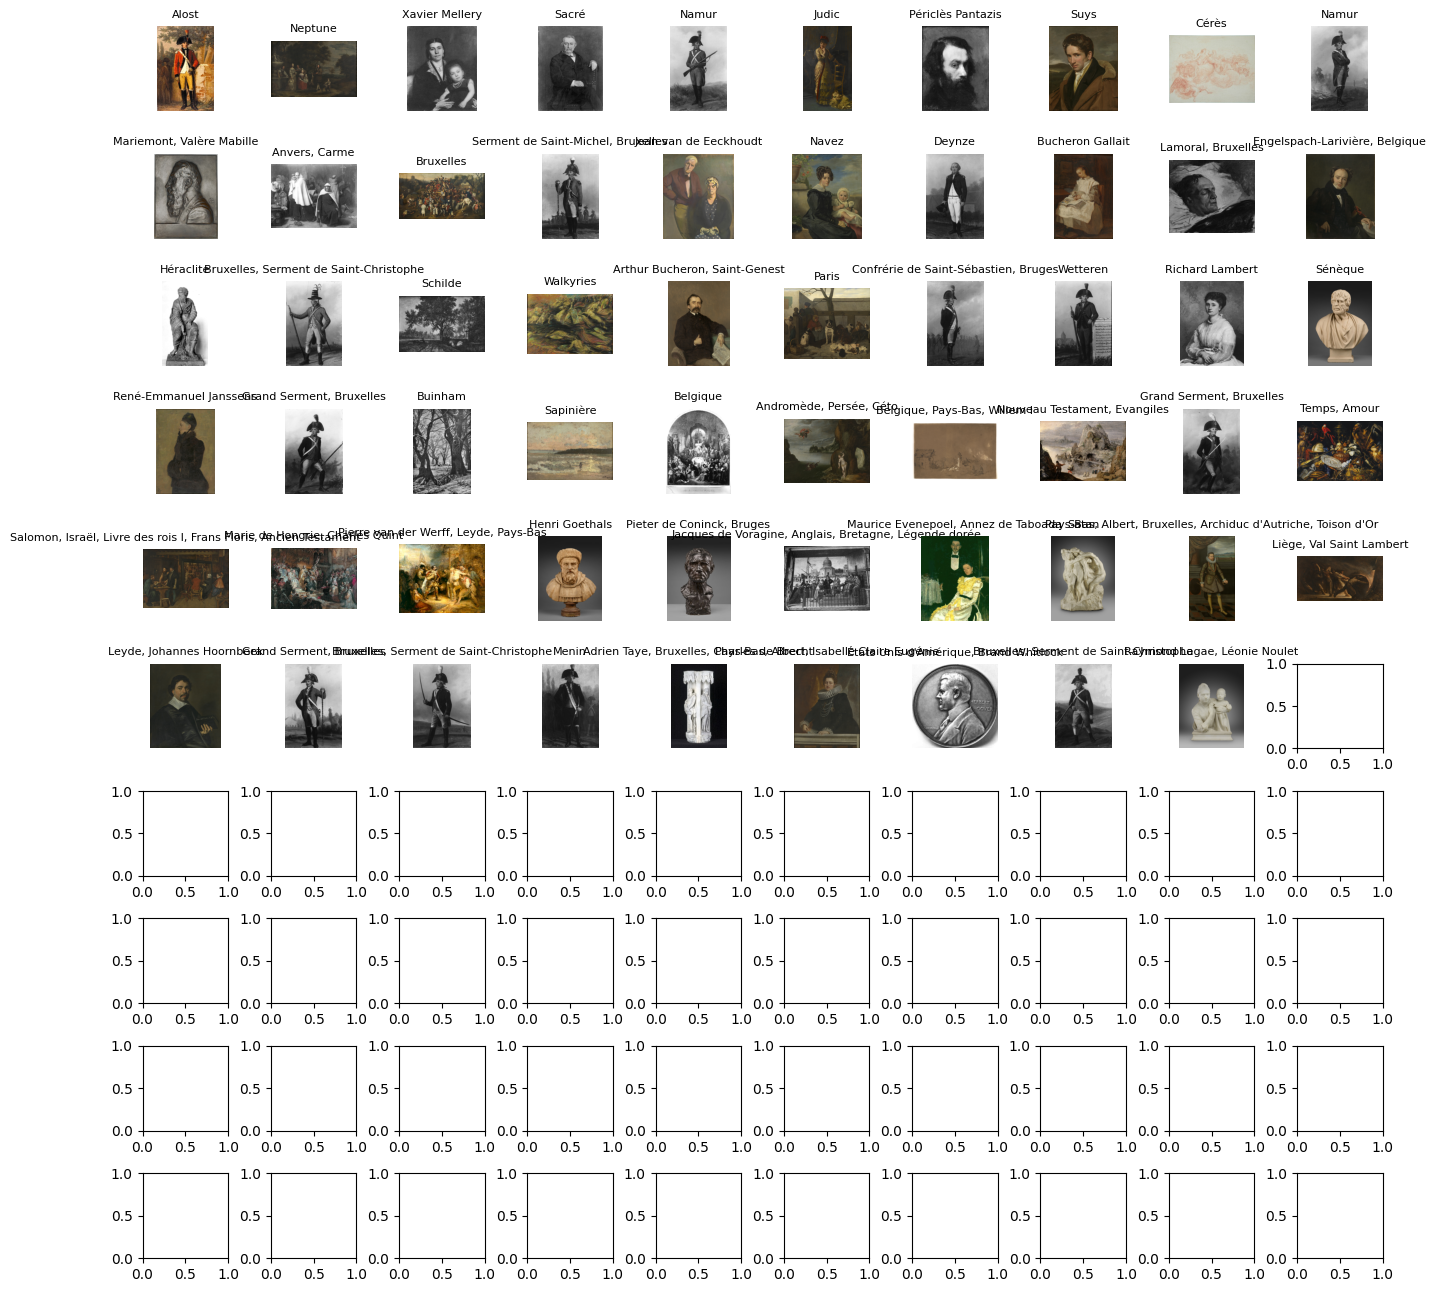

In [ ]:
import ast

worse_performing_indexes_per_model = {}
for model_name in ["march_finetuned"]:
    df = data[model_name]["exploded"]
    
    proper_nouns_to_mean_rank = {}
    nb_artworks_to_mean_rank = {}
    recordID_to_mean_rank = {}

    for i, row in df.iterrows():
        # Get the ranks
        ranks = ast.literal_eval(row["ranks"])
        entry_exploded = DATA_EXPLODED.iloc[i]

        proper_nouns = entry_exploded["proper_nouns"]
        proper_nouns_to_mean_rank[proper_nouns] = np.mean(ranks)

        recordIDs = entry_exploded["recordID"]
        for rankIndex, recordID in enumerate(recordIDs):
            if recordID not in recordID_to_mean_rank:
                recordID_to_mean_rank[recordID] = []
            rank_for_recordID = ranks[rankIndex]    
            recordID_to_mean_rank[recordID].append(rank_for_recordID)

        nb_artworks = len(recordIDs)
        if nb_artworks not in nb_artworks_to_mean_rank:
            nb_artworks_to_mean_rank[nb_artworks] = []
        for rank in ranks:
            nb_artworks_to_mean_rank[nb_artworks].append(rank)

    for recordID in recordID_to_mean_rank.keys():
        recordID_to_mean_rank[recordID] = np.mean(recordID_to_mean_rank[recordID])

    # Order the proper_nouns_to_mean_rank by mean rank from high to low
    proper_nouns_to_mean_rank = dict(sorted(proper_nouns_to_mean_rank.items(), key=lambda item: item[1], reverse=True))

    # Order the recordID_to_mean_rank by mean rank from high to low
    recordID_to_mean_rank = dict(sorted(recordID_to_mean_rank.items(), key=lambda item: item[1], reverse=True))
    recordIDs_keys = list(recordID_to_mean_rank.keys())

    proper_nouns_keys = list(proper_nouns_to_mean_rank.keys())

    ranks_df = pd.DataFrame(columns=["Rank", "Worst performing proper noun (mean rank)", "Best performing proper noun (mean rank)"])
    k = 10
    for i in range(k):
        index_bad = i
        index_good = -(i+1)

        proper_noun_bad = proper_nouns_keys[index_bad]
        proper_noun_good = proper_nouns_keys[index_good]

        mean_rank_bad = proper_nouns_to_mean_rank[proper_noun_bad]
        mean_rank_good = proper_nouns_to_mean_rank[proper_noun_good]

        ranks_df.loc[len(ranks_df)] = [i+1, f"{proper_noun_bad} ({mean_rank_bad})", f"{proper_noun_good} ({mean_rank_good})"]

    plt.figure(figsize=(10, 5))
    nb_artworks = list(nb_artworks_to_mean_rank.keys())
    nb_artworks = sorted(nb_artworks)
    min_nb_artworks = min(nb_artworks)
    max_nb_artworks = max(nb_artworks)

    X = []
    STDs = []
    Y = []

    for i in range(min_nb_artworks, max_nb_artworks+1):
        if i not in nb_artworks_to_mean_rank:
            continue
        M = nb_artworks_to_mean_rank[i]
        S = np.std(M)
        M = np.mean(M)
        X.append(i)
        STDs.append(S)
        Y.append(M)
    
    if False:
        # Plot 3 rows of 10 artworks that perform bad
        fig, axs = plt.subplots(10, 10, figsize=(16, 16))
        fig.subplots_adjust(hspace=0.5, wspace=0.5)
        axs = axs.flatten()
        for i in range(100):
            ax = axs[i]
            recordID = recordIDs_keys[i]
            image_path = get_image_path_from_recordID(recordID)

            # Get from the ATTACHED dataframe the proper nouns
            proper_nouns = DATA_ATTACHED[
                DATA_ATTACHED["recordID"] == recordID
            ]["proper_nouns"].values[0]

            # Get the image
            image = Image.open(image_path)
            ax.imshow(image, cmap='gray')
            ax.axis('off')
            ax.set_title(proper_nouns, fontsize=8)
                
            
        plt.suptitle(f"Worst performing proper nouns for {model_name} model", fontsize=16)
        plt.show()

ranks_df